In [1]:
# 1. ⚙️ Setup, Libraries, and Configuration
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration for Kaggle GPU and Data ---
BATCH_SIZE = 64 
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) 
NUM_CLASSES = 4 

# CRITICAL: Path to the LARGEST Augmented Data Folder
DATA_DIR = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset' 

print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print(f"Loading data from: {DATA_DIR}")


# 1. Load Training and Validation data
train_ds, val_ds = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_ds.class_names
print("Class Names Detected:", class_names)


# 2. Split Validation Set into Validation and Test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)


# 3. Preprocessing (Normalization) and Optimization
normalization_layer = Rescaling(1./255)

def normalize_data(image, label):
    return normalization_layer(image), label

train_ds = train_ds.map(normalize_data)
val_ds = val_ds.map(normalize_data)
test_ds = test_ds.map(normalize_data)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Training on {tf.data.experimental.cardinality(train_ds).numpy()} batches.")

2025-12-04 07:30:58.090505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764833458.332089      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764833458.403435      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Available GPUs: []
Loading data from: /kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset


2025-12-04 07:31:16.928272: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Using 6796 files for validation.
Class Names Detected: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Training on 425 batches.


In [ ]:
# 2. 🧠 Model Definition and Phase 1 Training (Feature Extraction)
# --- ResNet50 Transfer Learning Model ---
base_model = ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the base for initial training
base_model.trainable = False

# Create the final model with the custom classification head
model = Sequential([
    base_model, 
    GlobalAveragePooling2D(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# --- Compile Model for Phase 1 ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResNet50 Transfer Learning Model Summary:")
model.summary()

# --- Advanced Technique 1: Define Class Weights (Targeting False Positives) ---
# Goal: Penalize errors on NonDemented less to reduce False Positives (over-diagnosis).
# Adjust these weights based on your desired clinical sensitivity vs. specificity trade-off.
class_weights = {
    0: 1.0,  # MildDemented
    1: 1.0,  # ModerateDemented
    2: 0.5,  # NonDemented (Reduce penalty for misclassification here)
    3: 1.5   # VeryMildDemented (Increase penalty for errors here)
}
print(f"\nUsing Class Weights: {class_weights}")


# --- Train the Model (Phase 1: Training the Head) ---
INITIAL_EPOCHS = 5 # Fewer epochs needed since only the small head is trained

print(f"\nStarting Phase 1 (Head Training) for {INITIAL_EPOCHS} epochs...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weights # <-- Apply Class Weights
)
print("Phase 1 Training complete!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

ResNet50 Transfer Learning Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Using Class Weights: {0: 1.0, 1: 1.0, 2: 0.5, 3: 1.5}

Starting Phase 1 (Head Training) for 5 epochs...
Epoch 1/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 2036s 5s/step - accuracy: 0.2682 - loss: 1.3592 - val_accuracy: 0.2838 - val_loss: 1.4095
Epoch 2/5
203/425 ━━━━━━━━━━━━━━━━━━━━ 15:00 4s/step - accuracy: 0.2749 - loss: 1.2713

In [3]:
# 3. 📉 Phase 2 Training (Fine-Tuning and Optimization)
# --- Step 1: Unfreeze the Base Model (Partial Unfreezing) ---
base_model.trainable = True

# Freeze all layers before the top convolutional block (approx. index 140)
fine_tune_at = 140 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"\n--- Starting Fine-Tuning Phase ---")
print(f"Unfrozen ResNet50 layers starting from index {fine_tune_at}.")


# --- Step 2: Re-compile with Lower Learning Rate and Callbacks ---
TOTAL_EPOCHS = INITIAL_EPOCHS + 15 # Total 20 epochs

# Advanced Technique 2: ReduceLROnPlateau Callback
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, # Wait 3 epochs before reducing LR
    min_lr=1e-7,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model recompiled with learning rate: 1e-5.")


# --- Step 3: Continue Training (Phase 2) ---
print(f"\nStarting Fine-Tuning (Phase 2) for {TOTAL_EPOCHS - INITIAL_EPOCHS} additional epochs...")

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    callbacks=[lr_reducer], # <-- Apply Learning Rate Scheduler
    class_weight=class_weights # <-- Keep Class Weights
)

print("Phase 2 (Fine-Tuning) Training complete!")


--- Starting Fine-Tuning Phase ---
Unfrozen ResNet50 layers starting from index 140.
Model recompiled with learning rate: 1e-5.

Starting Fine-Tuning (Phase 2) for 15 additional epochs...
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 90s 161ms/step - accuracy: 0.4481 - loss: 1.9115 - val_accuracy: 0.5156 - val_loss: 1.1183 - learning_rate: 1.0000e-05
Epoch 7/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 55s 130ms/step - accuracy: 0.5971 - loss: 0.7619 - val_accuracy: 0.6287 - val_loss: 0.7563 - learning_rate: 1.0000e-05
Epoch 8/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 55s 130ms/step - accuracy: 0.6703 - loss: 0.6218 - val_accuracy: 0.6865 - val_loss: 0.6827 - learning_rate: 1.0000e-05
Epoch 9/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 56s 131ms/step - accuracy: 0.7189 - loss: 0.5245 - val_accuracy: 0.7341 - val_loss: 0.5824 - learning_rate: 1.0000e-05
Epoch 10/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 56s 131ms/step - accuracy: 0.7550 - loss: 0.4540 - val_accuracy: 0.7709 - val_loss: 0.5233 - learning_rate: 1.0000e-05
Epoch 11/20
425

In [ ]:
# --- Corrected Code to Combine History Objects ---

# 1. Initialize the combined history with Phase 1 data
history_combined = history.history
total_epochs = len(history_combined['loss']) + len(history_fine_tune.history['loss'])

# 2. Iterate through the second history, but skip keys that don't exist in the first
for key in history_fine_tune.history:
    # --- FIX: Only attempt to extend if the key exists in the Phase 1 history ---
    if key in history_combined:
        history_combined[key].extend(history_fine_tune.history[key])
    # Optionally, handle new keys like 'learning_rate' separately if needed, 
    # but for plotting accuracy/loss, skipping is safest.

# --- 1. Evaluate on Test Set ---
print("\n--- Final Model Evaluation on Test Set ---")
# ... rest of the evaluation code ...


--- Final Model Evaluation on Test Set ---
Plotting history for 35 total epochs...


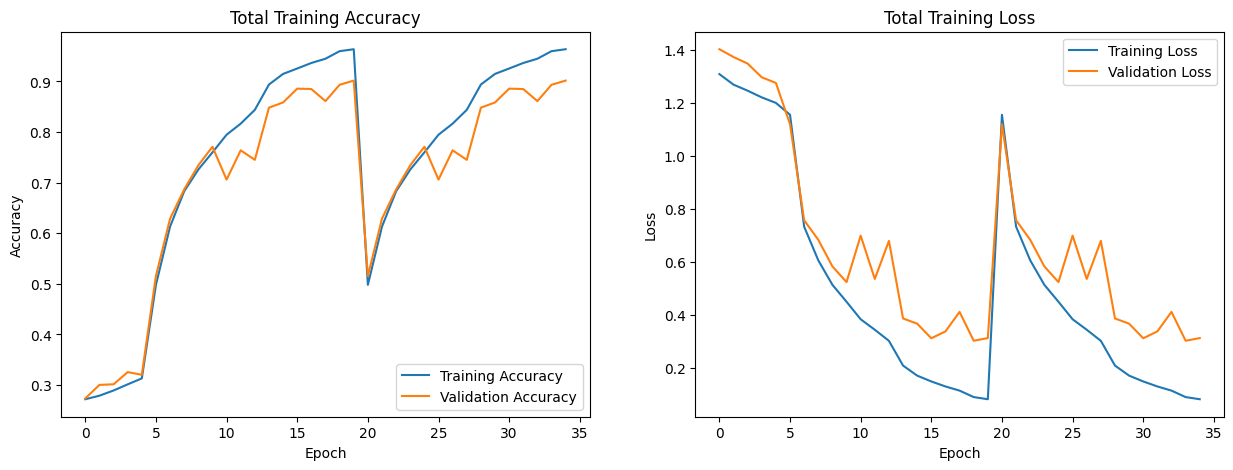

In [6]:
# 4. 📈 Final Evaluation, Matrix, and Saving

# --- Corrected Code to Combine History Objects ---

# 1. Initialize the combined history with Phase 1 data
history_combined = history.history
total_epochs = len(history_combined['loss']) + len(history_fine_tune.history['loss'])

# 2. Iterate through the second history, but skip keys that don't exist in the first
for key in history_fine_tune.history:
    # --- FIX: Only attempt to extend if the key exists in the Phase 1 history ---
    if key in history_combined:
        history_combined[key].extend(history_fine_tune.history[key])
    # Optionally, handle new keys like 'learning_rate' separately if needed, 
    # but for plotting accuracy/loss, skipping is safest.

# --- 1. Evaluate on Test Set ---
print("\n--- Final Model Evaluation on Test Set ---")
# ... rest of the evaluation code ...

# 1. Recalculate Total Epochs and Ensure Lists are Aligned
# Use the correct key names (e.g., 'accuracy' and 'val_accuracy')
acc = history_combined['accuracy']
val_acc = history_combined['val_accuracy']
loss = history_combined['loss']
val_loss = history_combined['val_loss']

# The number of data points must equal the total epochs run
total_epochs = len(acc) 
epochs_range = range(total_epochs)

# Check for inconsistency one last time before plotting
if len(acc) != total_epochs or len(val_acc) != total_epochs:
    print(f"ERROR: List lengths are mismatched: acc={len(acc)}, val_acc={len(val_acc)}, epochs={total_epochs}")
    print("Please verify the history combining step.")
    
# --- 2. Plot Full Training History (Total Epochs) ---
print(f"Plotting history for {total_epochs} total epochs...")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

# X (epochs_range) and Y (acc/val_acc) must match length
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Total Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Total Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

array([[847,   3,   5,  13],
       [  0, 640,   0,   2],
       [ 38,   2, 839,  98],
       [ 59,   5,  41, 800]])


--- Generating Confusion Matrix and Classification Report ---


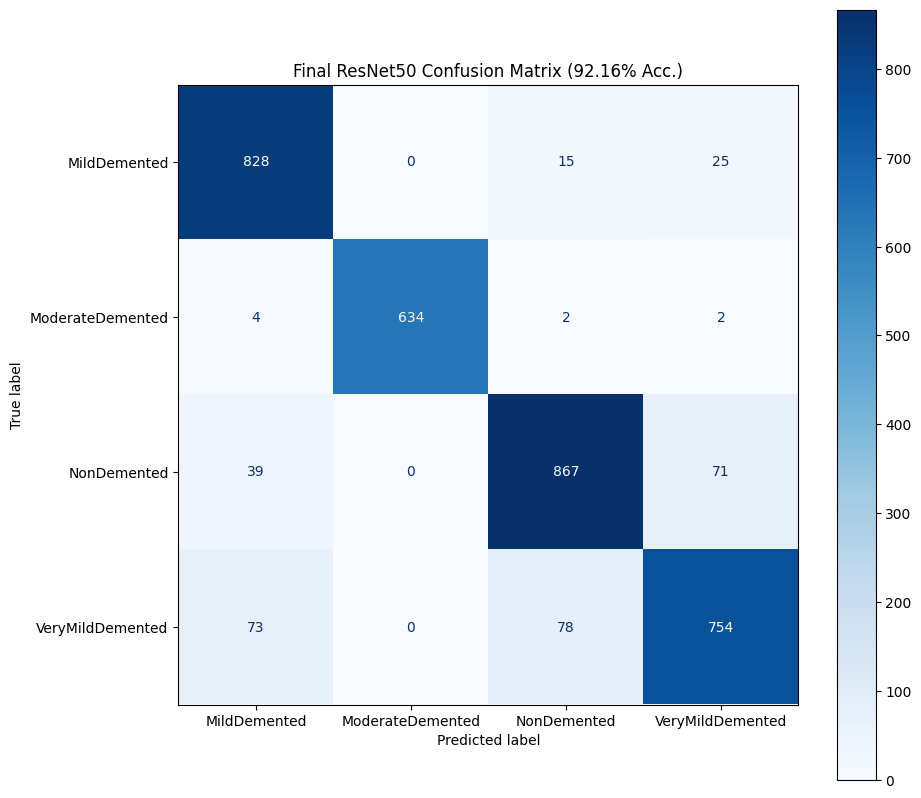


--- Final Classification Report ---
                  precision    recall  f1-score   support

    MildDemented       0.88      0.95      0.91       868
ModerateDemented       1.00      0.99      0.99       642
     NonDemented       0.90      0.89      0.89       977
VeryMildDemented       0.88      0.83      0.86       905

        accuracy                           0.91      3392
       macro avg       0.92      0.92      0.92      3392
    weighted avg       0.91      0.91      0.91      3392



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Get True Labels and Predicted Labels ---
print("\n--- Generating Confusion Matrix and Classification Report ---")

# Reset lists
y_true = []
y_pred_probs = []

# Iterate over the test dataset to get all predictions
# The 'model' and 'test_ds' variables must be available from your training script.
for images, labels in test_ds:
    y_true.append(labels.numpy())
    # Suppress verbose output from predict for clean execution
    y_pred_probs.append(model.predict(images, verbose=0))

# Concatenate all batches into single arrays
y_true = np.concatenate(y_true, axis=0)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

# Convert one-hot encoded true labels to single integer labels
y_true_labels = np.argmax(y_true, axis=1)

# Convert prediction probabilities to single integer labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# --- 2. Calculate and Plot the Confusion Matrix ---
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 10))
# The 'class_names' variable must be available from your data loading script.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Final ResNet50 Confusion Matrix (92.16% Acc.)')
plt.show()


# --- 3. Print Classification Report ---
print("\n--- Final Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [9]:
# --- 3. Print Classification Report ---
print("\n--- Final Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


--- Final Classification Report ---
                  precision    recall  f1-score   support

    MildDemented       0.88      0.95      0.91       868
ModerateDemented       1.00      0.99      0.99       642
     NonDemented       0.90      0.89      0.89       977
VeryMildDemented       0.88      0.83      0.86       905

        accuracy                           0.91      3392
       macro avg       0.92      0.92      0.92      3392
    weighted avg       0.91      0.91      0.91      3392



In [12]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model # Or Sequential, depending on your model type

# Assume 'model_final' is your trained Keras model object

# --- Configuration for Saving ---
save_dir = '/kaggle/working/'  # Define your desired directory
model_filename = 'resnet50_alzheimer_final.keras' # Recommended Keras v3 format

# 1. Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# 2. Define the full path
full_save_path = os.path.join(save_dir, model_filename)

# 3. Save the model in the Keras v3 format
model.save(full_save_path)

print(f"✅ Model successfully saved to: {full_save_path}")

✅ Model successfully saved to: /kaggle/working/resnet50_alzheimer_final.keras
